In [575]:
import importlib
importlib.reload(VRPSolver)

<module 'VRPSolver' from 'C:\\Users\\Saldern\\jupyter\\vrp\\VRPSolver.py'>

In [585]:
import glob
import scipy

import VRPSolver
%matplotlib inline

instances = glob.glob('./instances/*.txt')
slv = VRPSolver.VRPSolver(instances[7], 10, 8)

101


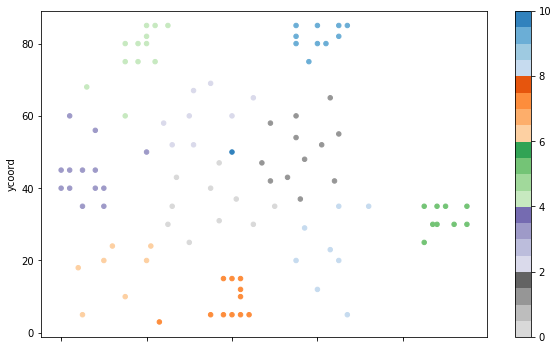

In [592]:
slv.df.plot.scatter(0, 1, c=slv.df.cluster, colormap='tab20c_r', figsize=(10,6))
print(slv.df.shape[0])

In [593]:
slv.df.groupby('cluster').demand.sum()

cluster
0     138
1     155
2     127
3     237
4     237
5     150
6     139
7     207
8     134
9     200
10      0
Name: demand, dtype: int32

In [594]:
n_vehicles, initial_solution, cost = slv.get_initial_solution(0)
print(n_vehicles, cost, slv.is_solution_feasible(initial_solution))

C:\Users\Saldern\jupyter\vrp\VRPSolver.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Saldern\jupyter\vrp\VRPSolver.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  print('===== Route after insert: =====')


add route [0, 2, 45, 5, 3, 8, 6, 7, 46, 4, 60, 0]
add route [0, 1, 79, 0]
add route [0, 12, 16, 11, 53, 10, 13, 17, 0]
add route [0, 14, 15, 47, 9, 0]
add route [0, 73, 78, 0]
add route [0, 21, 19, 23, 18, 22, 49, 20, 25, 24, 0]
add route [0, 48, 77, 0]
add route [0, 31, 27, 30, 29, 28, 32, 34, 26, 0]
add route [0, 33, 0]
add route [0, 42, 39, 44, 38, 41, 35, 43, 37, 0]
add route [0, 36, 40, 0]
add route [0, 63, 51, 76, 84, 85, 89, 0]
add route [0, 62, 50, 0]
add route [0, 65, 83, 64, 99, 57, 66, 56, 0]
add route [0, 82, 90, 52, 0]
add route [0, 92, 95, 71, 67, 81, 54, 94, 93, 96, 80, 0]
add route [0, 72, 91, 0]
add route [0, 98, 69, 88, 61, 55, 68, 70, 100, 0]
add route [0, 59, 86, 87, 97, 74, 58, 0]
add route [0, 75, 0]
20 2225.861999564882 True


In [595]:
initial_solution

[[0, 2, 45, 5, 3, 8, 6, 7, 46, 4, 60, 0],
 [0, 1, 79, 0],
 [0, 12, 16, 11, 53, 10, 13, 17, 0],
 [0, 14, 15, 47, 9, 0],
 [0, 73, 78, 0],
 [0, 21, 19, 23, 18, 22, 49, 20, 25, 24, 0],
 [0, 48, 77, 0],
 [0, 31, 27, 30, 29, 28, 32, 34, 26, 0],
 [0, 33, 0],
 [0, 42, 39, 44, 38, 41, 35, 43, 37, 0],
 [0, 36, 40, 0],
 [0, 63, 51, 76, 84, 85, 89, 0],
 [0, 62, 50, 0],
 [0, 65, 83, 64, 99, 57, 66, 56, 0],
 [0, 82, 90, 52, 0],
 [0, 92, 95, 71, 67, 81, 54, 94, 93, 96, 80, 0],
 [0, 72, 91, 0],
 [0, 98, 69, 88, 61, 55, 68, 70, 100, 0],
 [0, 59, 86, 87, 97, 74, 58, 0],
 [0, 75, 0]]

Начальное решение выглядит так

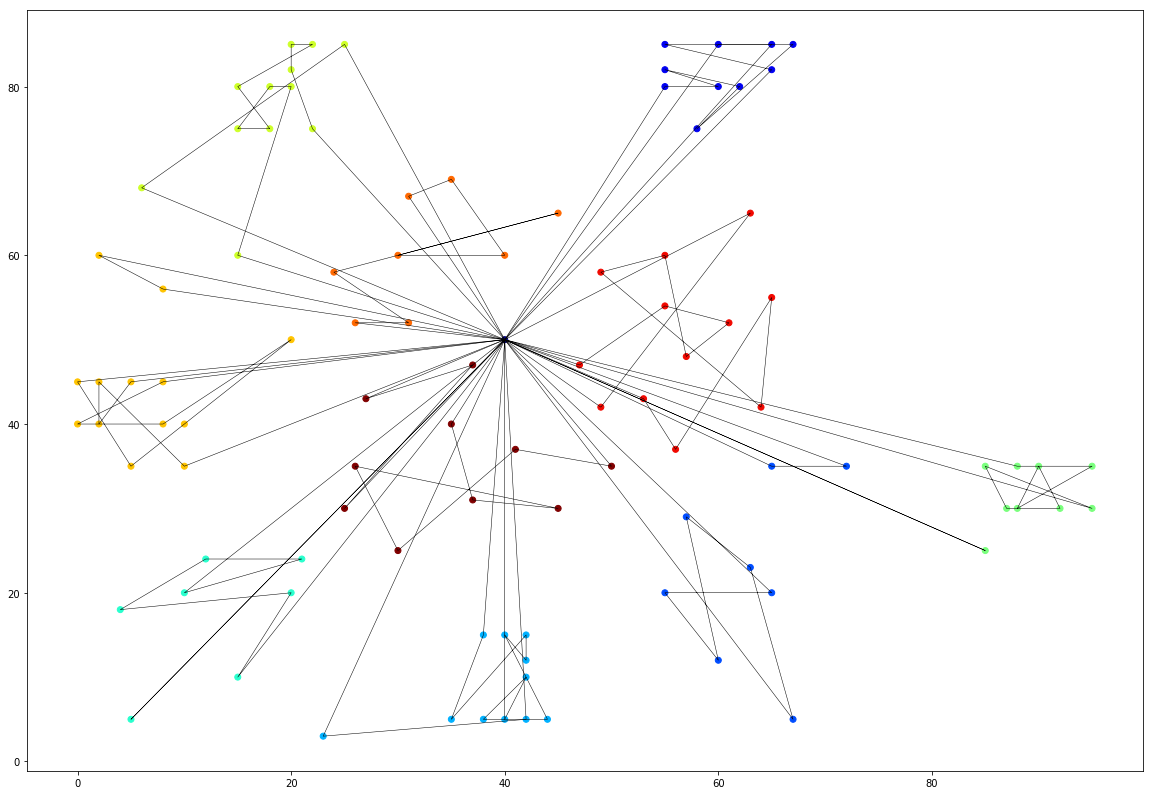

In [596]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,14))
plt.scatter(slv.df.xcoord, slv.df.ycoord, c=slv.df.cluster, cmap='jet_r')
for route in initial_solution:
    plt.plot(slv.df.xcoord[route], slv.df.ycoord[route], linewidth=0.5, color='black')

In [597]:
slv.df.loc[~slv.df.index.isin(slv.routed_clients)]

,xcoord,ycoord,demand,ready_time,due_date,service_time,cluster
cust_no,,,,,,,


In [598]:
import joblib

with joblib.Parallel(1) as parallel:
    solution = np.array(list(map(np.array, initial_solution)))
    old_cost = slv.solution_cost(solution)
    solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost, parallel=parallel)
    while old_cost > slv.solution_cost(solution):
        old_cost = slv.solution_cost(solution)
        solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost, parallel=parallel)
        print(old_cost)
    for i in range(10):
        print('Perturbing')
        Perturbation(solution)
        print('Looking for better and feasible')
        print(slv.is_solution_feasible(solution), old_cost, slv.solution_cost(solution))
        n = 0
        while not slv.is_solution_feasible(solution):
            n += 1
            solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost,  parallel=parallel)
        while old_cost < slv.solution_cost(solution):
            n += 1
            solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost,  parallel=parallel)
        old_cost = slv.solution_cost(solution)
        if (old_cost == slv.solution_cost(solution)):
            print('Best solution found, done, cost = {}'.format(old_cost))
            break
        print('Found after {} iterations, cost = {}'.format(n, old_cost))


2028.50173946252
1947.4846880938073
1907.730109628935
1892.4545775226406
1887.331448537046
1887.1110620687166
Perturbing
Looking for better and feasible
True 1887.1110620687166 1918.4726306391085
Best solution found, done, cost = 1886.7020253717174


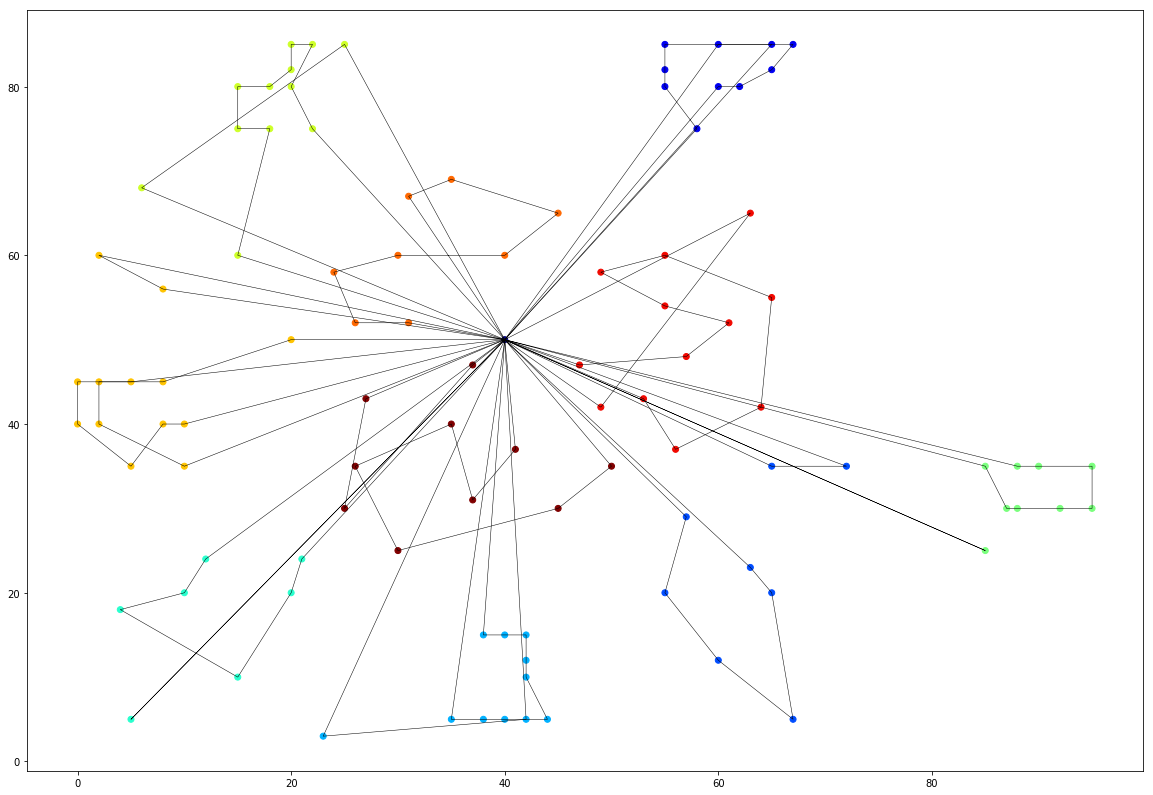

In [599]:
plt.figure(figsize=(20,14))
plt.scatter(slv.df.xcoord, slv.df.ycoord, c=slv.df.cluster, cmap='jet_r')
for route in solution:
    plt.plot(slv.df.xcoord[route], slv.df.ycoord[route], linewidth=0.5, color='black')

In [470]:
import numpy as np

class History:
    def __init__(self, s=None, c=None):            
        self.solutions = list()
        self.cost = list()
        if s is not None:
            self.solutions.append(s)
        if c is not None:
            self.cost.append(c)

    def append(self, s, c):
        self.solutions.append(s)
        self.cost.append(c)
        
    def __getitem__(self, i):
        return self.solutions[i], self.cost[i]
    
    def __print__(self):
        return self.solutions, self.cost
        
    def __str__(self):
        return '[{}]'.format(', '.join(['{:.3f}'.format(c) for s, c in zip (self.solutions, self.cost)]))
    
        
def LocalSearch(solution, is_feasible, cost, parallel):
    def _2op_move(route):
        def after_swap_cost(route, client_i, client_2i):
            route[client_i], route[client_2i] = route[client_2i], route[client_i]
            cost = slv.route_cost(route)
            return cost
        if len(route) < 4:
            return route
        swaps = [(i+1, j+i+1) for i in range(len(route[1:-2])) for j in range(len(route[i+1:-1])) if i != j]
        best_swap = np.argmin([after_swap_cost(np.copy(route), i, j) for i, j in swaps])
        client_2i, client_i = swaps[best_swap]
        route[client_i], route[client_2i] = route[client_2i], route[client_i]
        return route
    
    old_cost = cost(solution)
    new_solution = np.array(parallel(joblib.delayed(_2op_move)(np.copy(route)) for route in solution))
    if not is_feasible(new_solution) or old_cost <= cost(new_solution):
        return solution
    else:
        return new_solution

        
def Perturbation(solution):
    def double_bridge(route):
        subroutes = np.array_split(route[1:-1], 4)
        for i in subroutes:
            i[0], i[-1] = i[-1], i[0]

        return np.hstack([0] + subroutes + [0])
    
    route_i = np.random.randint(0, len(solution))
    while len(solution[route_i]) <= 9:
        route_i = np.random.randint(0, len(solution))
    route = solution[route_i]
    solution[route_i] = double_bridge(route)

In [341]:
a = np.arange(10)*3
print(a)
subroutes = np.array_split(a[1:-1], 4)
print(subroutes)
for i in subroutes:
    i[0], i[-1] = i[-1], i[0]

np.hstack([0] + subroutes + [0])

[ 0  3  6  9 12 15 18 21 24 27]
[array([3, 6]), array([ 9, 12]), array([15, 18]), array([21, 24])]


array([ 0,  6,  3, 12,  9, 18, 15, 24, 21,  0])